## X-ray image loading and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier


from tensorflow.keras.layers import Input
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers, regularizers
from keras.callbacks import EarlyStopping

### Now that the files have been moved to their respective labels, we can use the image generator to begin modeling analysis

In [41]:
data_dir = 'Classes'


#create test generator for final model evaluation(20% of entire dataset)
data_generator = ImageDataGenerator(1./255).flow_from_directory(
       data_dir, 
       target_size=(128, 128), batch_size=6700, color_mode='grayscale', class_mode='binary')

# #create train generator for model training and validation(80% of dataset). Will create validation split with TTS from train set
# train_generator = ImageDataGenerator(1./255).flow_from_directory(
#        data_dir, 
#        target_size=(128, 128), batch_size=5360, color_mode='grayscale', class_mode='binary').

#Create the datasets
data_images, data_labels = next(data_generator)
# test_images, test_labels = next(test_generator)

Found 6700 images belonging to 2 classes.


C:\Users\Adonis McQueen\anaconda3\envs\learn-env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


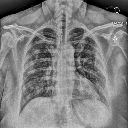

In [42]:
#sample photo
array_to_img(data_images[0])

In [43]:
#labels
data_generator.class_indices

{'deceased': 0, 'discharged': 1}

#### checking image and label shapes for model creation

In [44]:
data_images.shape

(6700, 128, 128, 1)

In [45]:
data_labels.shape

(6700,)

In [7]:
# test_images.shape

(1340, 128, 128, 1)

In [8]:
# test_labels.shape

(1340,)

#### Creating validation data from TTS in order to train CNN models

In [70]:
#train test split to generate training and test data

X = data_images
y = data_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
#creating 2nd train and validation set from initial training set

x = X_train
Y = y_train

X_train2, X_val, y_train2, y_val = train_test_split(x, Y, test_size=0.2, random_state=42)

In [73]:
#investigating shapes of train and validation sets
print(np.shape(X_train2))
print(np.shape(X_val))
print(np.shape(y_train2))
print(np.shape(y_val))

(4288, 128, 128, 1)
(1072, 128, 128, 1)
(4288,)
(1072,)


In [48]:
#function to plot epochs vs loss and accuracy for train and validation/test set
def visualize_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['test_loss', 'train_loss'])
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show();
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['test_acc', 'train_acc'])
    plt.title('Epochs vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show();

In [135]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    
    return sns.heatmap(matrix, annot=True, cmap='BuPu', fmt='.4g', xticklabels=['Deceased', 'Discharged'], 
                       yticklabels=['Deceased', 'Discharged']), plt.yticks(rotation=0)

## Baseline dummy classifier

In [74]:
#dummy classifier to compare baseline models to


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train2, y_train2)
dummy.predict(X_val)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [75]:
#dummy classifier score
dummy.score(X_val, y_val)

0.6194029850746269

### To start, a simple CNN model will be used with no dropouts or multiple dense layers.

In [76]:
#baseline CNN model
np.random.seed(424)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [107]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 127008)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8128576   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 8,128,961
Trainable params: 8,128,961
Non-trainable params: 0
_________________________________________________________________


### Accuracy will be the primary metric of evaluation. A low learning rate is used to improve model learning. SGD is the preferred optimizer; previous iterations with Adam yielded lower accuracy rates.

In [77]:
#compile and fit the training data, then validate the fit with validation data
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
optimizer = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results = model.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 14s 412ms/step - loss: 10.1109 - acc: 0.5257 - val_loss: 0.7222 - val_acc: 0.5578
Epoch 2/50
34/34 [==============================] - 14s 408ms/step - loss: 0.6944 - acc: 0.5795 - val_loss: 0.6929 - val_acc: 0.5868
Epoch 3/50
34/34 [==============================] - 14s 403ms/step - loss: 0.6741 - acc: 0.5951 - val_loss: 0.6896 - val_acc: 0.5896
Epoch 4/50
34/34 [==============================] - 14s 399ms/step - loss: 0.6644 - acc: 0.6073 - val_loss: 0.6873 - val_acc: 0.5989
Epoch 5/50
34/34 [==============================] - 14s 401ms/step - loss: 0.6555 - acc: 0.6199 - val_loss: 0.6860 - val_acc: 0.5989
Epoch 6/50
34/34 [==============================] - 14s 402ms/step - loss: 0.6472 - acc: 0.6297 - val_loss: 0.6835 - val_acc: 0.6007
Epoch 7/50
34/34 [==============================] - 14s 399ms/step - loss: 0.6388 - acc: 0.6369 - val_loss: 0.6815 - val_acc: 0.6101
Epoch 8/50
34/34 [==============================] - 14s 401ms/step -

#### Model results with train and validation sets

In [78]:
results_train = model.evaluate(X_train2, y_train2)

134/134 [==============================] - 5s 35ms/step - loss: 0.4254 - acc: 0.8088


In [79]:
results_val = model.evaluate(X_val, y_val)

34/34 [==============================] - 1s 35ms/step - loss: 0.6685 - acc: 0.6278


#### Visualizing results

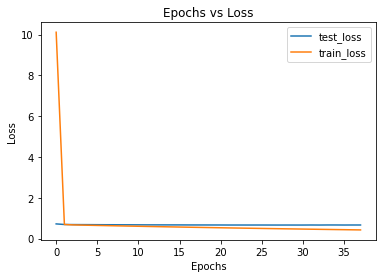

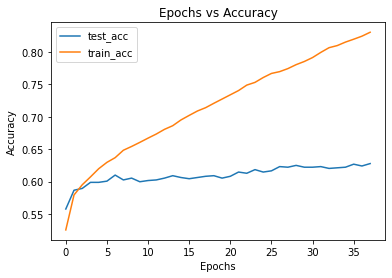

In [80]:
visualize_results(results)

(<AxesSubplot:>,
 (array([0.5, 1.5]), [Text(0, 0.5, 'Deceased'), Text(0, 1.5, 'Discharged')]))

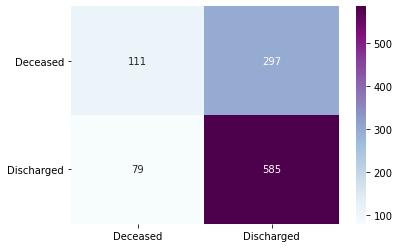

In [136]:
#confusion matrix for model predictions

label_pred = (model.predict(X_val) > 0.5).astype(int)

plot_matrix(y_val, label_pred)



### Insight: This model appears to begin overfitting to the training data, and the validation accuracy does not increase. Will adding addtional convolution layers increase performance?

In [82]:
# Increasing convolutional layers
np.random.seed(424)
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (2, 2), activation='relu'))
model2.add(layers.MaxPooling2D((3, 3)))

model2.add(layers.Flatten())
model2.add(layers.Dense(96, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [108]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 16)        8208      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 64)        4160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5184)             

In [83]:
optimizer = keras.optimizers.SGD(lr=0.00001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results2 = model2.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/50
34/34 [==============================] - 27s 808ms/step - loss: 1.7252 - acc: 0.5161 - val_loss: 1.3767 - val_acc: 0.4086
Epoch 2/50
34/34 [==============================] - 27s 804ms/step - loss: 1.1940 - acc: 0.5063 - val_loss: 1.3217 - val_acc: 0.4114
Epoch 3/50
34/34 [==============================] - 27s 803ms/step - loss: 1.1598 - acc: 0.5072 - val_loss: 1.2794 - val_acc: 0.4142
Epoch 4/50
34/34 [==============================] - 27s 800ms/step - loss: 1.1318 - acc: 0.5091 - val_loss: 1.2447 - val_acc: 0.4170
Epoch 5/50
34/34 [==============================] - 27s 801ms/step - loss: 1.1088 - acc: 0.5100 - val_loss: 1.2134 - val_acc: 0.4170
Epoch 6/50
34/34 [==============================] - 27s 800ms/step - loss: 1.0892 - acc: 0.5131 - val_loss: 1.1853 - val_acc: 0.4198
Epoch 7/50
34/34 [==============================] - 27s 805ms/step - loss: 1.0714 - acc: 0.5170 - val_loss: 1.1618 - val_acc: 0.4198
Epoch 8/50
34/34 [==============================] - 27s 803ms/step - 

#### Model2 predictions and visualizing results

In [84]:
results_train2 = model2.evaluate(X_train2, y_train2)

134/134 [==============================] - 6s 47ms/step - loss: 0.8185 - acc: 0.5548


In [85]:
results_test2 = model2.evaluate(X_val, y_val)

34/34 [==============================] - 2s 45ms/step - loss: 0.8635 - acc: 0.5056


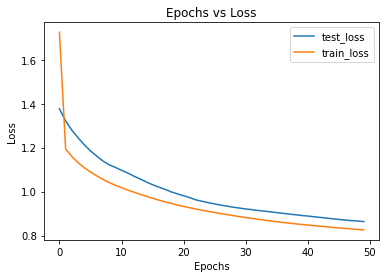

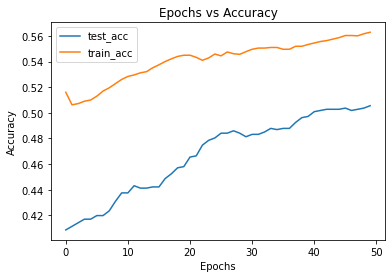

In [86]:
# train_pred = (model2.predict(X_train2) > 0.5).astype(int)
val_pred = (model2.predict(X_val) > 0.5).astype(int)

visualize_results(results2)

(<AxesSubplot:>,
 (array([0.5, 1.5]), [Text(0, 0.5, 'Deceased'), Text(0, 1.5, 'Discharged')]))

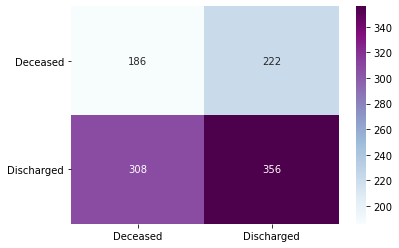

In [137]:
plot_matrix(y_val, val_pred)


### While the 2nd model resolves the overfitting issue, the accuracy has decreased for both training and validation sets. Will regularization improve accuracy scores for better predictions? 

In [88]:
#adding regularization penalty to model

model3 = models.Sequential()
model3.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(96, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Dense(1, activation='sigmoid'))

In [109]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 96)        110688    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        55360     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 64)       

In [89]:
optimizer = keras.optimizers.SGD(lr=0.0001)
early_stopping2 = [EarlyStopping(monitor='val_loss', patience=10)]
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results3 = model3.fit(X_train2,
                    y_train2,
                    callbacks=early_stopping2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_val, y_val), shuffle=False)

Epoch 1/25
67/67 [==============================] - 106s 2s/step - loss: 2.2641 - acc: 0.5459 - val_loss: 1.9567 - val_acc: 0.5634
Epoch 2/25
67/67 [==============================] - 105s 2s/step - loss: 1.9703 - acc: 0.5683 - val_loss: 1.9378 - val_acc: 0.5765
Epoch 3/25
67/67 [==============================] - 105s 2s/step - loss: 1.9458 - acc: 0.5837 - val_loss: 1.9284 - val_acc: 0.5886
Epoch 4/25
67/67 [==============================] - 106s 2s/step - loss: 1.9343 - acc: 0.5882 - val_loss: 1.9240 - val_acc: 0.5886
Epoch 5/25
67/67 [==============================] - 105s 2s/step - loss: 1.9258 - acc: 0.5935 - val_loss: 1.9160 - val_acc: 0.5933
Epoch 6/25
67/67 [==============================] - 106s 2s/step - loss: 1.9189 - acc: 0.5944 - val_loss: 1.9105 - val_acc: 0.6045
Epoch 7/25
67/67 [==============================] - 105s 2s/step - loss: 1.9107 - acc: 0.6021 - val_loss: 1.9070 - val_acc: 0.6157
Epoch 8/25
67/67 [==============================] - 106s 2s/step - loss: 1.9048 - a

#### Visualizing results for model 3

In [90]:
results_train3 = model3.evaluate(X_train2, y_train2)

134/134 [==============================] - 27s 199ms/step - loss: 1.8553 - acc: 0.6413


In [91]:
results_test3 = model3.evaluate(X_val, y_val)

34/34 [==============================] - 7s 193ms/step - loss: 1.8706 - acc: 0.6287


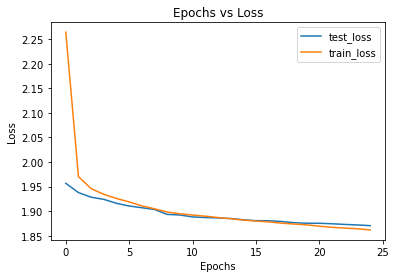

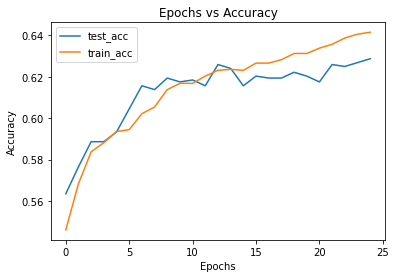

In [92]:
visualize_results(results3)

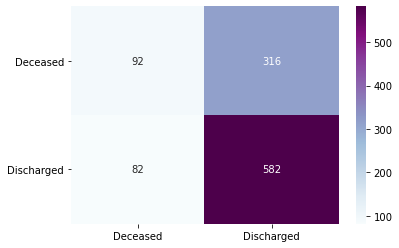

In [138]:
val_pred3 = (model3.predict(X_val) > 0.5).astype(int)
plot_matrix(y_val, val_pred3);


### Insight: model 1 performed the best out of all the models, so it will be used to generate probability predictions for the train and test sets

In [94]:
#fit against entire train set and validate with test set, then generate predictions
np.random.seed(424)
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [95]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
optimizer = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

results_final = model.fit(X_train,
                    y_train,
                    callbacks=early_stopping,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
42/42 [==============================] - 18s 421ms/step - loss: 10.4586 - acc: 0.5944 - val_loss: 0.6734 - val_acc: 0.6149
Epoch 2/50
42/42 [==============================] - 17s 416ms/step - loss: 0.6710 - acc: 0.6062 - val_loss: 0.6667 - val_acc: 0.6149
Epoch 3/50
42/42 [==============================] - 18s 419ms/step - loss: 0.6698 - acc: 0.6058 - val_loss: 0.6659 - val_acc: 0.6149
Epoch 4/50
42/42 [==============================] - 18s 419ms/step - loss: 0.6693 - acc: 0.6058 - val_loss: 0.6657 - val_acc: 0.6149
Epoch 5/50
42/42 [==============================] - 18s 419ms/step - loss: 0.6689 - acc: 0.6060 - val_loss: 0.6654 - val_acc: 0.6142
Epoch 6/50
42/42 [==============================] - 18s 418ms/step - loss: 0.6686 - acc: 0.6060 - val_loss: 0.6653 - val_acc: 0.6142
Epoch 7/50
42/42 [==============================] - 18s 417ms/step - loss: 0.6682 - acc: 0.6060 - val_loss: 0.6651 - val_acc: 0.6142
Epoch 8/50
42/42 [==============================] - 18s 419ms/step -

In [105]:
train_final = model.evaluate(X_train, y_train)

168/168 [==============================] - 6s 36ms/step - loss: 0.6097 - acc: 0.6448


In [106]:
test_final = model.evaluate(X_test, y_test)

42/42 [==============================] - 1s 35ms/step - loss: 0.6221 - acc: 0.6209


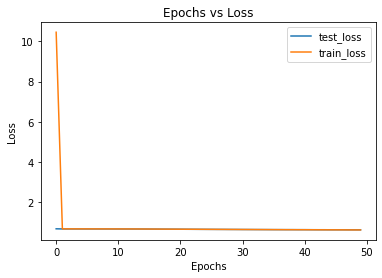

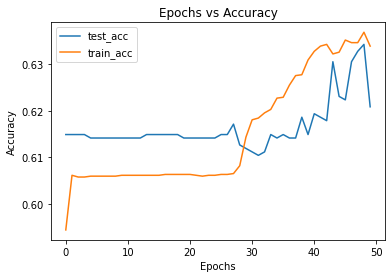

In [96]:
visualize_results(results_final)

In [97]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [98]:
train_predictions.shape

(5360, 1)

In [99]:
test_predictions

array([[0.41965514],
       [0.76471364],
       [0.7185861 ],
       ...,
       [0.6715141 ],
       [0.7298917 ],
       [0.5788402 ]], dtype=float32)

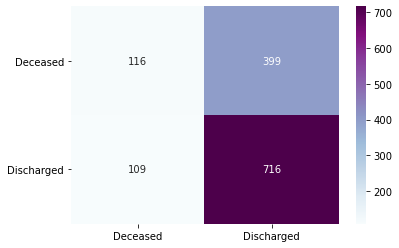

In [139]:

final_pred = (model.predict(X_test) > 0.5).astype(int)
plot_matrix(y_test, final_pred);


In [111]:
type(data_images)

numpy.ndarray

In [141]:
data_labels

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [119]:
len(data_generator.filenames)

6700

In [116]:
data_pred = model.predict(data_images)
data_pred

array([[0.81626177],
       [0.69117916],
       [0.4996497 ],
       ...,
       [0.7029867 ],
       [0.4996497 ],
       [0.5297894 ]], dtype=float32)

In [117]:
data_pred.shape

(6700, 1)

In [120]:
preds = data_pred.tolist()
pred_df = pd.DataFrame({'patient_id':data_generator.filenames, 'prediction':preds})
pred_df.head()

,patient_id,prediction
0,deceased\A003797-211.png,[0.8162617683410645]
1,deceased\A003797-213.png,[0.6911791563034058]
2,deceased\A003797-215.png,[0.49964970350265503]
3,deceased\A003797-217.png,[0.6613535284996033]
4,deceased\A003797-219.png,[0.5728612542152405]


In [ ]:
#save cleaned up df  
# cwd = os.getcwd()
# path = cwd + "/cnnpreds.csv"
# pred_df.to_csv(path, index=False)